In [1]:
import matplotlib.pyplot as plt
import torch
import zuko
import sys
sys.path.append("/home/kaechben/MDMACalo/")
from functools import partial
import matplotlib.pyplot as plt
import torch
import zuko
from utils.dataloader_calo import PointCloudDataloader
from utils.preprocess import DQ, DQLinear, LogitTransformer, ScalerBase, SqrtTransformer
import os
os.chdir("/home/kaechben/MDMACalo/")
bins = 5
middle=True
dm=PointCloudDataloader("calo",1024,scaler_path=".",middle=middle)
dm.setup("fit")

from functools import partial
def two_moons(n: int, sigma: float = 1e-1, cuda: bool = False):
    theta = 2 * torch.pi * torch.rand(n, device = 'cuda' if cuda else 'cpu')
    label = (theta > torch.pi).float()

    x = torch.stack((
        torch.cos(theta) + label - 1 / 2,
        torch.sin(theta) + label / 2 - 1 / 4,
    ), axis=-1)

    return torch.normal(x, sigma), label



/home/kaechben/MDMACalo/utils/helpers.py:1240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.a = torch.nn.Parameter(torch.tensor(coeffs[0]),requires_grad=True)
/home/kaechben/MDMACalo/utils/helpers.py:1241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.b = torch.nn.Parameter(torch.tensor(coeffs[1]),requires_grad=True)
/home/kaechben/MDMACalo/utils/helpers.py:1242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.c = torch.nn.Parameter(torch.tensor(coeffs[2]),requires_grad=True)
/home/kaechben/MDMACalo/utils/helpers.py:1243: Us

OrderedDict([('a', tensor(-0.0007)), ('b', tensor(0.0007)), ('c', tensor(-0.0205)), ('d', tensor(-0.0757)), ('e', tensor(0.6663)), ('f', tensor(0.1786)), ('n_std', tensor(1.1582)), ('n_mean', tensor(5.0479))])
100000
scaler_middle.gz
Scaler loaded
tensor(1.6006e+08)


In [2]:
%matplotlib inline
def trafo(x,y):
    y=(y+torch.rand_like(conds[:,1]))
    E=(x+10).exp()
    y=(y/E**(1/2))#.log()
    n_mean,n_std=y.mean(),y.std()
    y=(y-n_mean)/n_std
    return x,y,n_mean,n_std
def inv_trafo(x,y,n_mean,n_std):
    y=y*n_std+n_mean
    E=(x+10).exp()
    y=y*E**(1/2)
    print(y.sum())
    y=y.floor()
    print(y.sum())
    return E,y

conds=[]
for i in dm.train_dataloader():
    _,mask,x=i
    conds.append(x.reshape(-1,2))
conds=torch.cat(conds)
conds=conds[conds[:,1]>0]
x=conds[:,0]
y=(conds[:,1]*dm.avg_n)
print(y.sum())
x,y,n_mean,n_std=trafo(x,y)
print(n_mean,n_std,inv_trafo(x,y,n_mean,n_std)[1].sum())

tensor(1.5876e+08)
tensor(1.5881e+08)
tensor(1.5876e+08)
tensor(5.0480) tensor(1.1581) tensor(1.5876e+08)


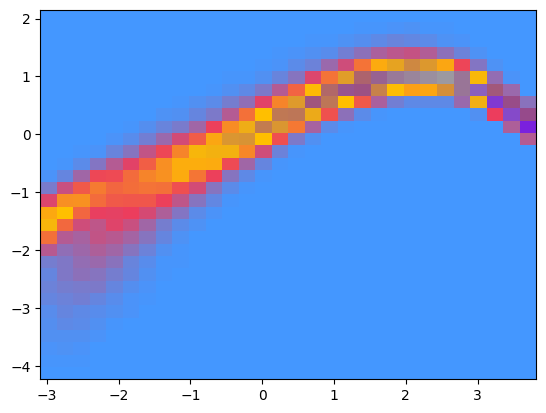

In [4]:




# _,xx,yy,_=plt.hist2d(x=x.numpy(),y=y.numpy(),bins=30);
plt.hist2d(x=x.numpy(),y=y.numpy(),bins=30);
data_loader=torch.utils.data.DataLoader(torch.cat((x.reshape(-1,1),y.reshape(-1,1)),1),batch_size=128,shuffle=True)


In [3]:
%matplotlib inline

rqs_flow = zuko.flows.NICE(
    features=1,
    context=1,
    transforms=1,
    univariate=zuko.transforms.MonotonicRQSTransform,
    shapes=[(bins,), (bins,), (bins - 1,)],
    hidden_features=[1024,10242,]
)

import h5py
import numpy as np

# conds[:,1]=conds[:,1]*dm.avg_n+torch.rand_like(conds[:,1])
# conds[:,1]/=dm.avg_n
# if not middle:
#     conds[:,1]=conds[:,1]/10y



def train(flow, use_label=False, batch_size=64, steps=100_000):

    flow = flow.cuda()
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    losses = []
    # for _ in range(10):
    for k in range(10):
        for i in data_loader:
            # i,_=two_moons(1024)
            y = i[:, 1:].cuda()
            x = i[:, :1].cuda()

            optimizer.zero_grad()
            loss = -flow(x).log_prob(y).mean()
            # loss = ((flow(x).sample()-y)**2).mean()
            loss.backward()
            optimizer.step()

            losses.append([loss.detach().cpu().item()])
        if (k % 1 == 0)  and k>0:

            print(f'({k:5d})', torch.tensor(losses).mean().item())

    plt.plot(torch.tensor(losses).numpy())
    plt.savefig("loss.png")
    flow = flow.cpu()
    return flow,losses
rqs_flow,losses=train(rqs_flow)



NameError: name 'data_loader' is not defined

In [6]:
class Nflow(torch.nn.Module):
    def __init__(self,n_mean=0.,n_std=1.):
        super(Nflow,self).__init__()
        bins=5
        self.flow= zuko.flows.NICE(
            features=1,
            context=1,
            transforms=3,
            univariate=zuko.transforms.MonotonicRQSTransform,
            shapes=[(bins,), (bins,), (bins - 1,)],
            hidden_features=[128, 128,128,128]
)
        self.n_mean=torch.nn.Parameter(torch.tensor(n_mean),requires_grad=False)
        self.n_std=torch.nn.Parameter(torch.tensor(n_std,requires_grad=False))
    def forward(self,x):
        return self.flow(x).sample()
flow=Nflow(n_mean,n_std)
flow.flow=rqs_flow
torch.save(flow.state_dict(),"ckpts/n_flow_{}.pt".format("middle" if middle else "big"))

/tmp/ipykernel_9913/2754311061.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.n_mean=torch.nn.Parameter(torch.tensor(n_mean),requires_grad=False)
/tmp/ipykernel_9913/2754311061.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.n_std=torch.nn.Parameter(torch.tensor(n_std,requires_grad=False))


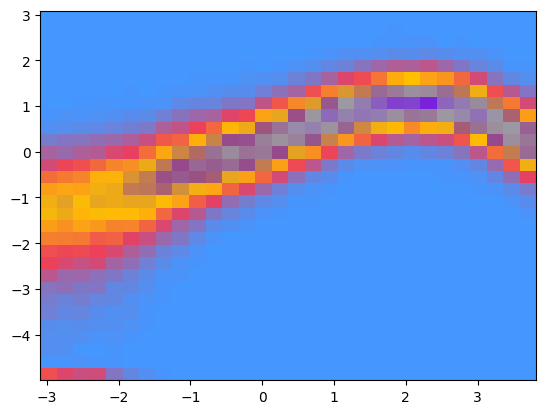

In [7]:
y_samples=flow(x.unsqueeze(1)).numpy()[:,0]
plt.hist2d(x=x.numpy(),y=y_samples,bins=(30,30));


In [5]:
# flow=Nflow()
# flow.load_state_dict(torch.load("ckpts/n_flow_{}.pt".format("middle" if middle else "big")))

import numpy as np
coeffs=np.polyfit(x.numpy().flatten(),y.numpy().flatten(),5)
print(coeffs)
n_pred=np.polyval(coeffs,x.numpy().flatten())
n_pred=inv_trafo(x,torch.from_numpy(n_pred),n_mean,n_std)[1].numpy().flatten()
corrfactor=(inv_trafo(x,y,n_mean,n_std)[1].numpy().flatten().sum())/n_pred.sum()
print(corrfactor)
# plt.scatter(conds[:,:1].numpy(),np.polyval(coeffs,conds[:,:1].numpy().flatten()))
# Define a custom power-law model
class PowerLawModel(torch.nn.Module):
    def __init__(self,coeffs, corrfactor,n_std=1):
        super(PowerLawModel, self).__init__()
        self.a = torch.nn.Parameter(torch.tensor(coeffs[0]),requires_grad=True)
        self.b = torch.nn.Parameter(torch.tensor(coeffs[1]),requires_grad=True)
        self.c = torch.nn.Parameter(torch.tensor(coeffs[2]),requires_grad=True)
        self.d = torch.nn.Parameter(torch.tensor(coeffs[3]),requires_grad=True)
        self.e = torch.nn.Parameter(torch.tensor(coeffs[4]),requires_grad=True)
        self.f = torch.nn.Parameter(torch.tensor(coeffs[5]),requires_grad=True)

        self.n_std=torch.nn.Parameter(n_std.detach().clone(),requires_grad=False)
        self.n_mean=torch.nn.Parameter(n_mean.detach().clone(),requires_grad=False)
    # def forward(self, x):
    def forward(self, x):
            return (self.a*x**5 +self.b * x**4 + self.c * x**3 + self.d * x**2 + self.e * x**1 + self.f)
        # return self.a * torch.pow(x, self.b)

model = PowerLawModel(coeffs,torch.tensor(n_mean),torch.tensor(n_std))


# plt.plot(x,(y.exp()+n_mean)/n_std,'o',color="blue")
# plt.plot(x,(np.exp(y_samples)+n_mean.item())/n_std.item(),'o',color="red")


torch.save(model.state_dict(),"ckpts/n_reg_{}.pt".format("middle" if middle else "big"))


[-7.22347890e-04  5.91154343e-04 -2.02381445e-02 -7.60018047e-02
  6.65606453e-01  1.75012938e-01]
tensor(1.5995e+08)
tensor(1.5990e+08)
tensor(1.5995e+08)
tensor(1.5990e+08)
1.0000015


/tmp/ipykernel_54386/3762398264.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model = PowerLawModel(coeffs,torch.tensor(n_mean),torch.tensor(n_std))


In [6]:
def create_mask(n, size=None):
    # Ensure n is a 1D tensor
    n = n.flatten()
    if size is None:
        size = n.max().int().item()
    # Create a range tensor [0, 1, 2, ..., size-1]
    range_tensor = torch.arange(size).unsqueeze(0).to(n.device)

    # Compare range_tensor with n to create the mask
    mask = range_tensor >= n.unsqueeze(1)

    return mask


In [2]:
torch.load("ckpts/n_reg_{}.pt".format("middle" if middle else "big"))

OrderedDict([('a', tensor(-0.0007, dtype=torch.float64)),
             ('b', tensor(0.0007, dtype=torch.float64)),
             ('c', tensor(-0.0207, dtype=torch.float64)),
             ('d', tensor(-0.0758, dtype=torch.float64)),
             ('e', tensor(0.6668, dtype=torch.float64)),
             ('f', tensor(0.1785, dtype=torch.float64)),
             ('n_std', tensor(1.1581)),
             ('n_mean', tensor(5.0480))])

In [5]:
model.load_state_dict(torch.load("ckpts/n_reg_{}.pt".format("middle" if middle else "big")))
model.state_dict()

OrderedDict([('a', tensor(-0.0007, dtype=torch.float64)),
             ('b', tensor(0.0007, dtype=torch.float64)),
             ('c', tensor(-0.0207, dtype=torch.float64)),
             ('d', tensor(-0.0758, dtype=torch.float64)),
             ('e', tensor(0.6668, dtype=torch.float64)),
             ('f', tensor(0.1785, dtype=torch.float64)),
             ('n_std', tensor(1.1581)),
             ('n_mean', tensor(5.0480))])

tensor(5.0480) tensor(1.1581)
tensor(1.5995e+08)
tensor(1.5990e+08)
tensor([ 131.,  122.,  138.,  ..., 5485., 5516., 5617.])
tensor(1.5995e+08)
tensor(1.5990e+08)
tensor(160120.9844)
tensor(160075.)
wtf tensor(1.5990e+08) tensor(160075.)
wtf tensor(0.3733) tensor(1.9938)


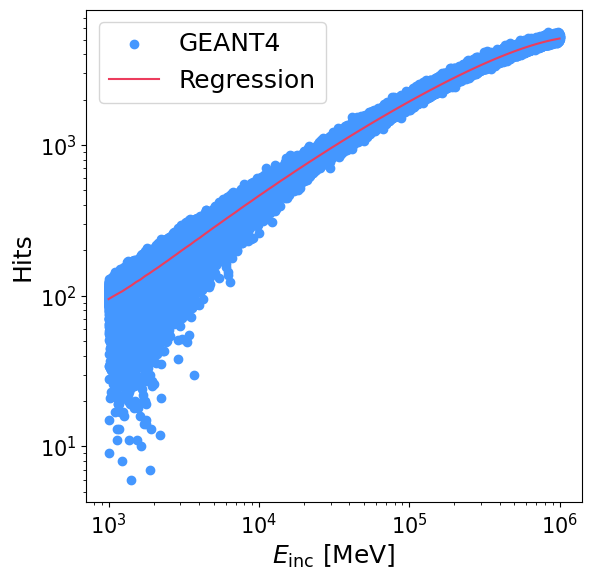

NameError: name 'create_mask' is not defined

In [6]:
import seaborn as sns
def plot_result(x,y):
    # conds=two_moons(10024)[0]


    x_data,y_data=inv_trafo(x,y,n_mean,n_std)
    print(y_data)

    i=0

    with torch.no_grad():



        # y = flow((x.unsqueeze(1))).sample().cpu().reshape(-1)
        # y_orig =y.clone().reshape(-1)
        y_pred = model(x.unsqueeze(1)).reshape(-1)

        # _,y_orig=inv_trafo(x,y_orig,n_mean,n_std)
        _,y_pred=inv_trafo(x,y_pred,n_mean,n_std)
        x_space=torch.linspace(x.min().item(),x.max().item(),100)
        y_pred=model(x_space).detach()
        x_space,y_pred=inv_trafo(x_space,y_pred,n_mean,n_std)

        # _,y=inv_trafo(x,y,n_mean,n_std)
        print("wtf",y_data.sum(),y_pred.sum())
        print("wtf",x.mean(),x.std())



    # plt.scatter(x_data.numpy(), y_orig.numpy(), label='Original Data')
    from my_cmaps import cmap
    plt.figure(figsize=(6.4, 6.4))
    plt.scatter(x_data.numpy(), y_data.numpy(), label='GEANT4',)
    plt.plot(x_space.numpy(), y_pred, label='Regression',color=sns.color_palette()[1])


    # plt.ylim(0,20000)
    # plt.plot(np.exp(np.linspace(conds[:,0].min().item(),conds[:,0].max().item(),100)+10),model(torch.linspace(conds[:,0].min().item(),conds[:,0].max().item(),100)).detach().numpy(), label='Fitted Model', color='green')
    plt.xscale('log')
    plt.yscale("log")
    plt.xlabel(r'$E_{\rm{inc}}$ [MeV]',fontsize=18)
    plt.ylabel(r'Hits', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.legend(fontsize=18)
    plt.savefig("plots/calo/nvsE.png")

    plt.show()
    print((~(create_mask(y_pred))).sum())
    # plt.figure(figsize=(4.8, 4.8))
    # plt.plot((conds[:, 0]+10).exp().numpy(), dm.avg_n*conds[:,1].numpy(), 'o',label='Original Data',alpha=0.01)
    # plt.plot(x.numpy(),y.numpy(), 'o',label='Cleaned Data',alpha=0.01)

    # plt.legend()
    # # plt.xscale('log')
    # plt.show()
torch.set_float32_matmul_precision("medium")

conds=[]
for i in dm.test_dataloader():
    _,mask,x,_=i
    conds.append(x.reshape(-1,2))
conds=torch.cat(conds)
conds=conds[conds[:,1]>0]
x=conds[:,0]
y=(conds[:,1]*dm.avg_n)
x,y,_,_=trafo(x,y)
print(n_mean,n_std)
plot_result(x,y)

In [38]:
n_pred = model((torch.tensor(dm.test_E).log()-10).reshape(-1,1))
_,n_pred=inv_trafo((torch.tensor(dm.test_E).log()-10).reshape(-1),n_pred.reshape(-1),n_mean,n_std)
print(n_pred.sum())

tensor(1.6012e+08, grad_fn=<SumBackward0>)
tensor(1.6007e+08, grad_fn=<SumBackward0>)
tensor(1.6007e+08, grad_fn=<SumBackward0>)


In [40]:
n_pred = model(torch.tensor(dm.test_E).reshape(-1,1).log()-10)
_,n_pred=inv_trafo(torch.tensor(dm.test_E).reshape(-1).log()-10,n_pred.reshape(-1),n_mean,n_std)
print(n_pred.sum())


tensor(1.6012e+08, grad_fn=<SumBackward0>)
tensor(1.6007e+08, grad_fn=<SumBackward0>)
tensor(1.6007e+08, grad_fn=<SumBackward0>)


In [37]:
torch.tensor(dm.test_E).float().sum()-(conds[:,0]+10).exp().sum()
(torch.tensor(dm.test_E).log()-10).float().sum()-(conds[:,0]).sum()

tensor(0.)